# Joint Line Fit

Create two data sets generated from a linear relation with the same slope but different constant offsets (intercepts).

Perform a chi-square fit to find the common slope and the two intercepts.

Then subclass the `LinFit` class in the [hyperfit](https://hyperfit.readthedocs.io/en/latest/) package to perform the same joint fit using `hyperfit`.

**Note**: This code is for the special case when one of the two data sets only has 2 points (and therefore has no associated scatter).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.special import loggamma
from scipy.optimize import minimize, differential_evolution

from corner import corner

import emcee
from hyperfit.linfit import LinFit

In [2]:
mpl.rc('font', size=14)

## Generate Data

Generate two independent data sets of two different sizes of the form

$$
\begin{align}
y_i^{(1)} &= ax_i^{(1)} + b^{(1)} \\
y_i^{(2)} &= ax_i^{(2)} + b^{(2)}
\end{align}
$$

I.e., the data share a slope but have different constants offsets. The data will also have separate covariances.

In [3]:
n, m = 15, 2

# Common slope but different intercepts.
a, b1, b2 = 2., 1., 2.

# Generate the first data set, and pack the results into the arrays data1 and cov1.
x1 = np.random.rand(n)
y1 = np.random.normal(a*x1 + b1, 0.2)
dx1, dy1, corrxy1 = (
    0.05 * np.random.rand(n) + 0.025,
    0.05 * np.random.rand(n) + 0.025,
    0.0 * (np.random.rand(n) - 0.5) # 2.0 * (np.random.rand(n) - 0.5)
)
data1, cov1 = np.empty((2, n)), np.empty((2, 2, n))
for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x1, y1, dx1, dy1, corrxy1)):
    cov1[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
    data1[:, i] = np.random.multivariate_normal([x, y], cov1[:, :, i])

# Generate the second data set, and pack the results into the arrays data2 and cov2.
x2 = np.random.rand(m)
y2 = np.random.normal(a*x2 + b2, 0.05)
dx2, dy2, corrxy2 = (
    0.05 * np.random.rand(m) + 0.025,
    0.05 * np.random.rand(m) + 0.025,
    0.0 * (np.random.rand(m) - 0.5) # 2.0 * (np.random.rand(m) - 0.5)
)
data2, cov2 = np.empty((2, m)), np.empty((2, 2, m))
for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x2, y2, dx2, dy2, corrxy2)):
    cov2[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
    data2[:, i] = np.random.multivariate_normal([x, y], cov2[:, :, i])

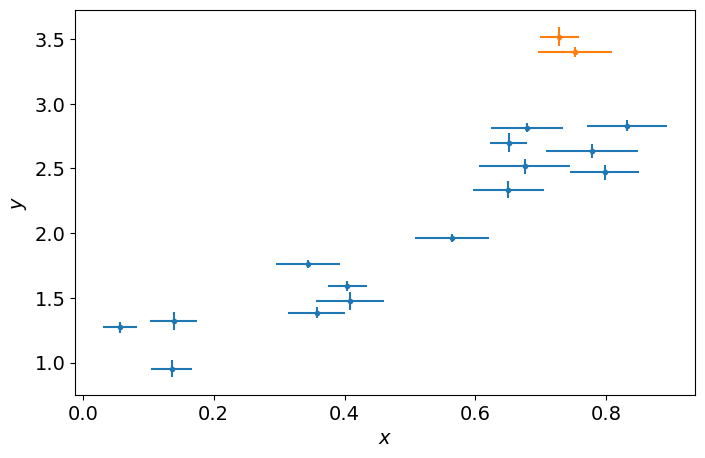

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
ax.set(xlabel='$x$', ylabel='$y$');

## Standard Fit

Attempt a standard $\chi^2$ fit to the data. Use both the uncertainties in $x$ and $y$, but ignore the covariances. Here we use the form of the $\chi^2$ defined in **Numerical Recipes in C++**, eq. 15.3.2:

$$
\chi^2(a,b) = \sum_{i}\frac{(y_i-ax_i-b)^2}{\sigma_{y_i}^2 + a^2\sigma_{x_i}^2}
$$

In this case, we divide the data in two and specify the parameters as the array `[a, b1, b2]`.

In [5]:
def chi2(params, data1, data2, cov1, cov2):
    """Chi-square function for joint slope fit to two data sets.
    
    Parameters
    ----------
    data1 : ndarray
        2xN array of [x1, y1] for data set 1.
    data2 : ndarray
        2xM array of [x2, y2] for data set 2.
    cov1 : ndarray
        2x2xN covariances for data set 1.
    cov2 : ndarray
        2x2xM covariances for data set 2.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    a, b1, b2 = params
    
    x1, y1 = data1[0], data1[1]
    varx1, vary1 = cov1[0,0], cov1[1,1]
    chi2_1 = np.sum((y1 - a*x1 - b1)**2 / (vary1 + a**2*varx1))
    
    x2, y2 = data2[0], data2[1]
    varx2, vary2 = cov2[0,0], cov2[1,1]
    chi2_2 = np.sum((y2 - a*x2 - b2)**2 / (vary2 + a**2*varx2))
    
    return chi2_1 + chi2_2

### Peform the Fit and Plot Results

Use the `BFGS` minimizer to find the best fit parameters.

Note that the result may depend sensitively on the initial seed values.

In [6]:
p0 = [1.5, 0.7, 1.2]
res = minimize(chi2, p0, args=(data1, data2, cov1, cov2), method='BFGS')
res

      fun: 65.84124170514816
 hess_inv: array([[ 0.0089423 , -0.00353987, -0.00647646],
       [-0.00353987,  0.00189194,  0.00256457],
       [-0.00647646,  0.00256457,  0.00832967]])
      jac: array([ 0.00000000e+00, -1.90734863e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 15
     njev: 16
   status: 0
  success: True
        x: array([2.53447229, 0.78158906, 1.61322181])

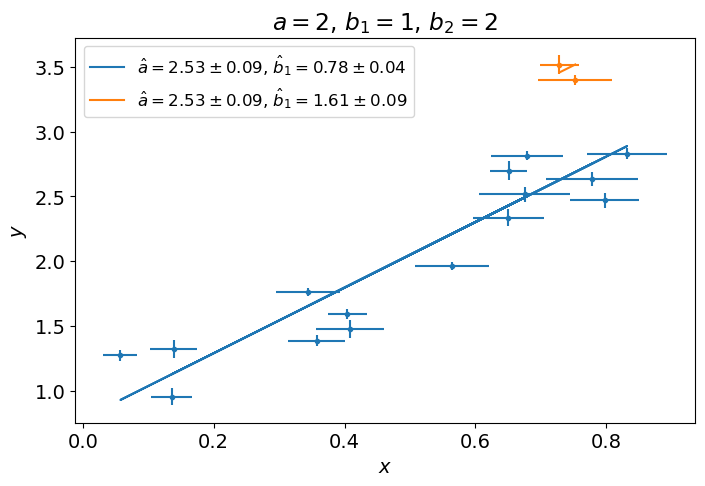

In [7]:
a_, b1_, b2_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
ax.plot(data1[0], a_*data1[0] + b1_, color=eb1[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))

eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))

ax.set(xlabel='$x$', ylabel='$y$',
       title='$a={:g}$, $b_1={:g}$, $b_2={:g}$'.format(a, b1, b2))
ax.legend(fontsize=12);

## Enable a Joint Fit in `hyperfit`

Here we set up a new class that can handle multiple data sets at once. The main condition is that the linear fits to the data always have a common slope.

In [8]:
def nlogl(params, datasets, covs):
    """Chi-square function for joint slope fit to two or more data sets.
    
    Parameters
    ----------
    datasets : list or ndarray
        m x 2xN array of [x1, y1] for each data set.
    cov : ndarray
        m x 2x2xN covariances for each data set.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    nsets = len(datasets)
    a = params[0]
    b = params[1:nsets+1]
    sigma = params[nsets+1:]
    
    nloglike = 0.
    for i in range(nsets-1): 
        data = datasets[i]
        cov = covs[i]
        x, dx2 = data[0], cov[0,0]
        y, dy2 = data[1], cov[1,1]
        dxy = cov[0,1]
        sy2 = sigma[i]**2 + a**2*dx2 + dy2 - 2*dxy*a
        nloglike += -0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b[i])**2/sy2)
        
    # Handle the last data set without the sigma
    data = datasets[-1]
    cov = covs[-1]
    x, dx2 = data[0], cov[0,0]
    y, dy2 = data[1], cov[1,1]
    dxy = cov[0,1]
    sy2 = a**2*dx2 + dy2 - 2*dxy*a
    nloglike += -0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b[-1])**2/sy2)
    
    return nloglike

# Minimization.
print('Differential evolution:')
bounds = [[-10., 10.], [-6., 6.], [-5., 5.], [0, 1]]
res = differential_evolution(nlogl, bounds, args=([data1, data2], [cov1, cov2]))
print(res)

# Initial guesses
slope = 1.5
intercepts = [0.7, 1.3]
sigmas = [0.2]
p0 = [slope] + intercepts + sigmas

print('\n\nBFGS minimization:')
res = minimize(nlogl, p0, args=([data1, data2], [cov1, cov2]), method='BFGS')
print(res)

Differential evolution:
     fun: -34.922659743757485
     jac: array([ 2.41584532e-05, -1.70530256e-05,  2.48689959e-05, -1.13686838e-05])
 message: 'Optimization terminated successfully.'
    nfev: 2285
     nit: 36
 success: True
       x: array([2.6714665 , 0.68251703, 1.51411552, 0.21343725])


BFGS minimization:
      fun: -34.92265974376727
 hess_inv: array([[ 0.08677071, -0.04098845, -0.06443717,  0.00674164],
       [-0.04098845,  0.02372307,  0.03045332, -0.0034034 ],
       [-0.06443717,  0.03045332,  0.05632743, -0.00505012],
       [ 0.00674164, -0.0034034 , -0.00505012,  0.00321266]])
      jac: array([-3.33786011e-06, -9.53674316e-07, -6.19888306e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 110
      nit: 18
     njev: 22
   status: 0
  success: True
        x: array([2.67146562, 0.68251752, 1.51411591, 0.21343721])


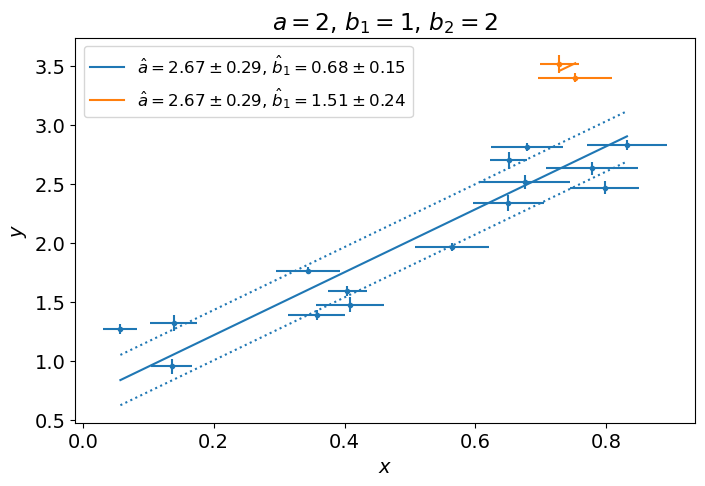

In [9]:
a_, b1_, b2_, sig1_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
x_ = np.linspace(np.min(data1[0]), np.max(data1[0]))
ax.plot(x_, a_*x_ + b1_, color=eb1[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))
ax.plot(x_, a_*x_ + b1_ + sig1_, ls=':', color=eb1[0].get_color())
ax.plot(x_, a_*x_ + b1_ - sig1_, ls=':', color=eb1[0].get_color())

eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')

x_ = np.linspace(np.min(data2[0]), np.max(data2[0]))
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))

ax.set(xlabel='$x$', ylabel='$y$',
       title='$a={:g}$, $b_1={:g}$, $b_2={:g}$'.format(a, b1, b2))
ax.legend(fontsize=12);

## Encapsulate Multi-Dataset Fits in a Single Class

Define a class `MultiLinFit` that takes in a list of datasets and covariances, each in the same format used by `LinFit` in the hyperfit package. I.e.,
* `data` are 2xN arrays, and `datasets` is a list of `data`.
* `cov` are 2x2xN arrays, and `covs` is a list of `cov`.

Note that the data sets can be different sizes.

While the `LinFit` class allows for higher-dimensional fits -- planes and hyperplanes in addition to lines -- this class only fits lines, as needed for the Tully-Fisher relation. It is assumed that all data sets share a common slope but have different intercepts and scatter parameters. The fit parameters are of the form

$$
\vec{\theta} = (a, b_1, b_2, \ldots, b_m, \sigma_1, \sigma_2, \ldots, \sigma_{m-1}),
$$

where $a$ is the common slope, $b_1,\ldots,b_m$ are the intercepts for the $m$ datasets, and $\sigma_1,\ldots,\sigma_{m-1}$ are the scatter parameters for each dataset.

In [10]:
class MultiLinFit:
    """Class to implement linear fits to multiple datasets, assuming
    a common slope but different intercepts across each set.
    
    Based on the hyperfit algorithm of Robotham and Obreschkow (PASP 2015)
    and the Python LinFit implementation of Howlett and Gordon
    (https://hyperfit.readthedocs.io/en/latest/).
    
    Attributes
    ----------
    nsets : int
        Number of data sets and covariances entered by user.
    ndims : int
        Dimensionality of the data (expect 2).
    ndata : ndarray
        Array giving the length of every input data vector.
    params : ndarray
        Best-fit linear parameters for the data sets.
    params_scatter : ndarray
        Best-fit scatters along the y-axis for each data set.
    
    Parameters
    ----------
    datasets : list or ndarray
        An Mx2xN array of 2xN data vectors.
    covs : list or ndarray
        An Mx2x2xN array of 2x2xN covariance matrices.
    weights : ndarray
        Array of weights for each data set. Unit weights if not specified.
    vertaxis : float
        Specify which coordinate axis in data is the 'vertical' one. Defaults to last axis (-1).
    """
    
    def __init__(self, datasets, covs, weights=None, vertaxis=-1):
        
        self.nsets = len(datasets)
        self.ndims = np.shape(datasets[0])[0]
        self.ndata = np.array([np.shape(data)[1] for data in datasets])
        self.datasets = datasets
        self.covs = covs
        self.data = None
        self.cov = None
        
        self.npars = 1 + self.nsets # slope + intercepts
        self.params = np.zeros(self.npars)
        self.params_scatter = np.zeros(self.nsets - 1) # (no scatter for the last data set)
        
        self.weights = [np.ones(n) for n in self.ndata] if weights is None else weights
        self.vertaxis = vertaxis
        
        self.param_bounds = None      # parameter fit bounds for all data sets
        
    # Log posterior function.
    def _lnpost(self, params):
        lnpost = 0.

        for i in range(self.nsets - 1):
            # Loop over individual data sets. 
            self.data = self.datasets[i]
            self.cov  = self.covs[i]
            
            # Set up parameter and bounds arrays for each data set.
            pars_i = np.array([params[0]] + [params[1+i]] + [params[self.nsets+1+i]])
            bounds_i = [self.param_bounds[0]] + \
                       [self.param_bounds[1+i]] + \
                       [self.param_bounds[self.nsets+1+i]]

            # Set up weights for each data set.
            weights = self.weights[i]
            
            # Sum over all data sets.
            lnprior = self._lnprior(pars_i, bounds_i)
            lnlike = self._lnlike(pars_i)                
            lnpost += np.sum(weights * lnlike) + lnprior
            
        ########################################################################
        # Handle the last data set separately (since it does not have scatter)
        #-----------------------------------------------------------------------
        self.data = self.datasets[-1]
        self.cov = self.covs[-1]
        
        # Set up parameter and bounds array for data set
        pars_i = np.array([params[0]] + [params[self.nsets]])
        bounds_i = [self.param_bounds[0]] + \
                   [self.param_bounds[self.nsets]]
        
        # Set up weights for data set
        weights = self.weights[-1]
        
        # Sum over all data sets
        lnprior = self._lnprior(pars_i, bounds_i)
        lnlike = self._lnlike(pars_i)
        lnpost += np.sum(weights * lnlike) + lnprior
        ########################################################################
        
        return lnpost
            
    # Log prior function.
    def _lnprior(self, params, bounds):
        lnprior = 0.
        for i, (param, bound) in enumerate(zip(params.T, bounds)):
            lnprior += np.where(np.logical_or(param < bound[0], param > bound[1]), -np.inf, 0.0)

        return lnprior
    
    # Log likelihood function.
    def _lnlike(self, params):
        
        if len(params) > 2:
            a, b, sigma = params
        else:
            a, b = params
            sigma = 0

        x, dx2 = self.data[0], self.cov[0,0]
        y, dy2 = self.data[1], self.cov[1,1]
        dxy = self.cov[0,1]
        
        sy2 = sigma**2 + a**2*dx2 + dy2 - 2*dxy*a
        lnlike = 0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b)**2/sy2)

        return lnlike
    
    def bessel_cochran(self, sigma):
        """Bessel-Cochran correction of sample scatter to population scatter.
        
        Parameters
        ----------
        sigma : ndarray
            1xM-1 array of scatters for the M input datasets.
        
        Returns
        -------
        sigma_corr : ndarray
            1xM-1 array of corrected scatter parameters.
        """
        sigma_corr = (
            np.sqrt(0.5 * (self.ndata[:-1]))
            * np.exp(loggamma(0.5 * ((self.ndata[:-1]) - self.ndims)) - loggamma(0.5 * ((self.ndata[:-1]) - self.ndims + 1.0)))
        ) * sigma

        return sigma_corr
    
    def optimize(self, bounds, tol=1e-6, verbose=False):
        """Find the best-fit line for multiple datasets, assuming a
        common slope across all sets but independent intercepts and scatters.
        
        Parameters
        ----------
        bounds : sequence
            Bounds for variables [a, b1, ..., bm, sig1, ..., sigm].
        tol : float
            Optimization tolerance.
        verbose : bool
            Print fit result.
            
        Returns
        -------
        params : ndarray
            Array of best-fit slope and intercepts [a, b1, b2, ..., bm]
        params_scatter : ndarray
            Array of vertical axis scatter parameters [sig1, sig2, ... sigm]
        log_posterior : float
            Value of ln(posterior) at the best fit point.
        """
        self.param_bounds = bounds
        res = differential_evolution(lambda *args: -self._lnpost(*args), self.param_bounds, tol=tol)

        if verbose:
            print(res)
        
        self.params = res.x[:-(self.nsets-1)]
        self.params_scatter = np.fabs(res.x[-(self.nsets-1):])
        self.params_scatter = self.bessel_cochran(self.params_scatter)
        return self.params, self.params_scatter, -res.fun
    
    def emcee(self, bounds, max_iter=100000, batchsize=1000, ntau=50.0, tautol=0.05, verbose=False):
        """Run MCMC using the emcee EnsembleSampler.
        
        The MCMC is seeded using a randomization of the best-fit values of the
        common slope, intercepts, and vertical scatters [a, b1, ..., bm, sig1, ..., sigm].
        
        Parameters
        ----------
        bounds : sequence
            Bounds for variables [a, b1, ..., bm, sig1, ..., sigm].
        max_iter : int
            Maximum number of MCMC iterations.
        batchsize : int
            Size of each batch. Convergence checked after each batch.
        ntau : float
            Minimum autocorrelation length to consider for convergence.
        tautol : float
            Maximum fractional deviation between successive autocorrelation lengths for convergence.
        verbose : bool
            Print out convergence statistics and progress bars if True.
            
        Returns
        -------
        mcmc_samples : ndarray
            Array of flattened and burned-in MCMC samples.
        mcmc_lnlike : ndarray
            Log-likelihood values of every MCMC sample.
        """

        # Set up emcee. Start the walkers in a small 1 percent ball around the best fit.
        # The best fit will set self.params and self.params_scatter.
        self.optimize(bounds, verbose=verbose)
        ndim = len(self.params) + len(self.params_scatter)
        nwalker = 4 * ndim
        seeds = np.asarray([
            [(0.01 * np.random.rand() + 0.995) * j for j in np.concatenate([self.params, self.params_scatter])]
            for _ in range(nwalker)
        ])

        sampler = emcee.EnsembleSampler(nwalker, ndim, self._lnpost)

        old_tau = np.inf
        niter = 0
        converged = 0
        while ~converged:
            sampler.run_mcmc(seeds, nsteps=batchsize, progress=verbose)
            tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
            converged = np.all(ntau * tau < niter)
            converged &= np.all(np.abs(old_tau - tau) / tau < tautol)
            old_tau = tau
            begin = None
            niter += 1000
            if verbose:
                print("Niterations/Max Iterations: ", niter, "/", max_iter)
                print("Integrated ACT/Min Convergence Iterations: ", tau, "/", np.amax(ntau * tau))
            if niter >= max_iter:
                break

        # Remove burn-in and and save the samples
        tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
        burnin = int(2 * np.max(tau))
        samples = sampler.get_chain(discard=burnin, flat=True).T
        mcmc_samples = samples
        mcmc_lnlike = sampler.get_log_prob(discard=burnin, flat=True)

        return mcmc_samples, mcmc_lnlike

In [11]:
mlf = MultiLinFit([data1, data2], [cov1, cov2])

In [12]:
mlf.params_scatter, mlf.ndata, mlf.ndims

(array([0.]), array([15,  2]), 2)

In [13]:
bounds = [[-10., 10.], [-10., 10.], [-10., 10.], [0., 2.]]
mlf.optimize(bounds, verbose=True)

     fun: -449.4292178637893
     jac: array([ 0.00358114,  0.00258069, -0.0030866 ,  0.004718  ])
 message: 'Optimization terminated successfully.'
    nfev: 4650
     nit: 76
 success: True
       x: array([2.65339498, 0.69104722, 1.5271848 , 0.21204245])


(array([2.65339498, 0.69104722, 1.5271848 ]),
 array([0.23218833]),
 449.4292178637893)

In [14]:
# Run an MCMC
bounds = [[-10., 10.], [-10., 10.], [-10., 10.], [0., 2.]]
mcmc_samples, mcmc_lnlike = mlf.emcee(bounds, max_iter=10000, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: -449.42921734724
     jac: array([ 0.00732712, -0.00248974, -0.00801492, -0.04221192])
 message: 'Optimization terminated successfully.'
    nfev: 4420
     nit: 72
 success: True
       x: array([2.653427  , 0.69103135, 1.52714259, 0.21203671])


100%|██████████| 1000/1000 [00:01<00:00, 583.11it/s]


Niterations/Max Iterations:  1000 / 10000
Integrated ACT/Min Convergence Iterations:  [32.64575552 31.15518415 25.85641084 30.35003707] / 1632.287775931096


100%|██████████| 1000/1000 [00:01<00:00, 593.03it/s]


Niterations/Max Iterations:  2000 / 10000
Integrated ACT/Min Convergence Iterations:  [28.45410463 26.33230096 32.73541118 39.82469862] / 1991.2349310635698


100%|██████████| 1000/1000 [00:01<00:00, 594.06it/s]


Niterations/Max Iterations:  3000 / 10000
Integrated ACT/Min Convergence Iterations:  [41.28782713 42.86672488 44.95977543 47.1492556 ] / 2357.462779817252


100%|██████████| 1000/1000 [00:01<00:00, 586.05it/s]


Niterations/Max Iterations:  4000 / 10000
Integrated ACT/Min Convergence Iterations:  [40.12439167 41.37488137 48.87344057 52.34736526] / 2617.368263136179


100%|██████████| 1000/1000 [00:01<00:00, 602.31it/s]


Niterations/Max Iterations:  5000 / 10000
Integrated ACT/Min Convergence Iterations:  [41.40377635 41.13308388 43.94711525 48.941412  ] / 2447.0706000770606


100%|██████████| 1000/1000 [00:01<00:00, 596.36it/s]


Niterations/Max Iterations:  6000 / 10000
Integrated ACT/Min Convergence Iterations:  [44.44639766 43.75664344 49.77611849 42.86224137] / 2488.805924461564


100%|██████████| 1000/1000 [00:01<00:00, 568.25it/s]


Niterations/Max Iterations:  7000 / 10000
Integrated ACT/Min Convergence Iterations:  [46.55232648 44.64283664 46.89451433 48.09857396] / 2404.9286979682124


100%|██████████| 1000/1000 [00:01<00:00, 586.58it/s]


Niterations/Max Iterations:  8000 / 10000
Integrated ACT/Min Convergence Iterations:  [51.61932589 45.67990662 47.70174948 49.07205553] / 2580.9662945713426


100%|██████████| 1000/1000 [00:01<00:00, 566.20it/s]


Niterations/Max Iterations:  9000 / 10000
Integrated ACT/Min Convergence Iterations:  [51.08623067 46.5072512  49.90968843 45.39764539] / 2554.311533663974


100%|██████████| 1000/1000 [00:01<00:00, 593.21it/s]


Niterations/Max Iterations:  10000 / 10000
Integrated ACT/Min Convergence Iterations:  [49.67806078 45.58074336 49.93943589 47.18998519] / 2496.971794417748
[2.66151789 0.68704239 1.52342087 0.21626772] [0.07264896 0.03808946 0.08119251 0.01477852]


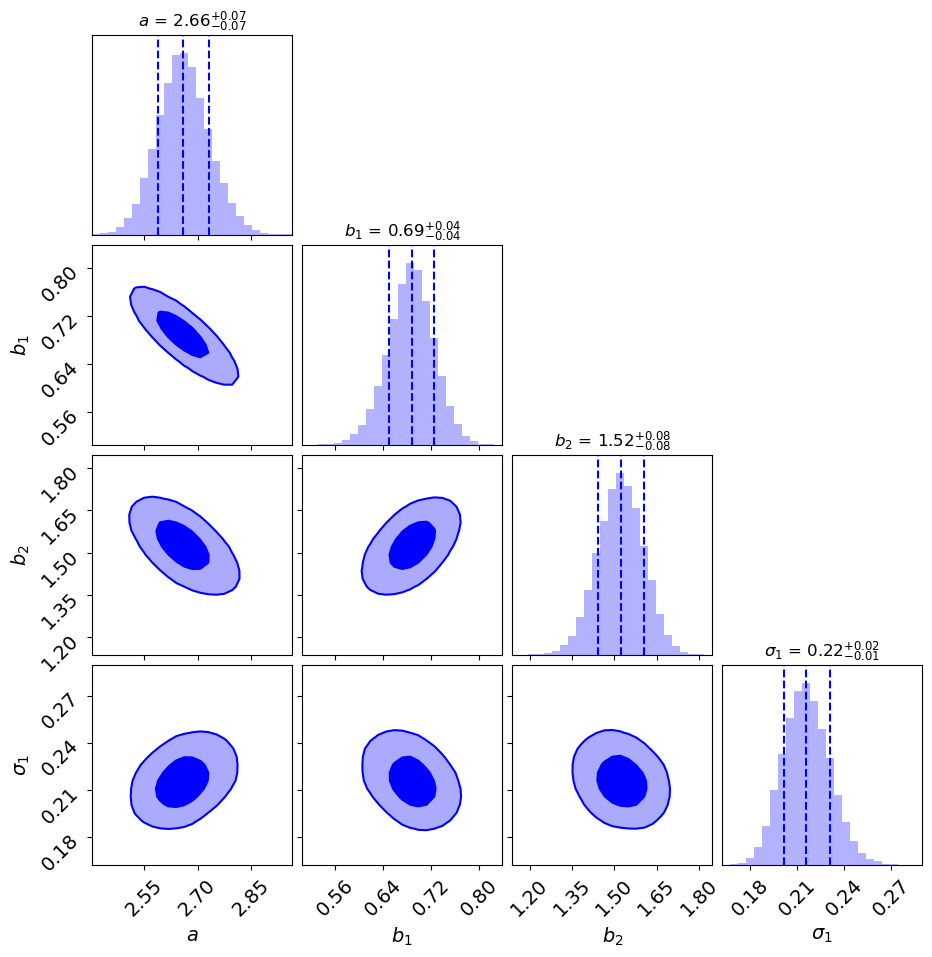

In [15]:
fig = corner(mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b_1$', '$b_2$', r'$\sigma_1$'], #r'$\sigma_2$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12});

# fig.savefig('multiline_fit_corner.png', dpi=100)

In [16]:
# Try the fit with my function
import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from line_fits import hyperfit_line_multi

In [17]:
# [data1, data2]
[cov1, cov2]

[array([[[ 0.00274954,  0.00236207,  0.00082114,  0.00302859,
           0.00128265,  0.00099979,  0.00091853,  0.00191468,
           0.00287689,  0.00263566,  0.00376183,  0.00067028,
           0.00324574,  0.00484396,  0.00495979],
         [-0.        , -0.        ,  0.        ,  0.        ,
           0.        ,  0.        , -0.        ,  0.        ,
           0.        ,  0.        , -0.        , -0.        ,
          -0.        ,  0.        ,  0.        ]],
 
        [[-0.        , -0.        ,  0.        ,  0.        ,
           0.        ,  0.        , -0.        ,  0.        ,
           0.        ,  0.        , -0.        , -0.        ,
          -0.        ,  0.        ,  0.        ],
         [ 0.00310743,  0.00093335,  0.00524943,  0.00115088,
           0.00503897,  0.0042892 ,  0.00155723,  0.00184508,
           0.00424364,  0.00437003,  0.00173278,  0.00166215,
           0.00111895,  0.00361947,  0.00287748]]]),
 array([[[ 0.0008604 ,  0.00316906],
         [-0.

In [18]:
a, b, sig, cov_ab, my_mcmc_samples, hf_test = hyperfit_line_multi([data1[0], data2[0]], 
                                                                  [data1[1], data2[1]], 
                                                                  [dx1, dx2], 
                                                                  [dy1, dy2], 
                                                                  bounds)

     fun: -449.42921690335
     jac: array([ 0.02137313,  0.01422222, -0.00651426, -0.0056616 ])
 message: 'Optimization terminated successfully.'
    nfev: 3815
     nit: 62
 success: True
       x: array([2.65346748, 0.69101648, 1.52711909, 0.2120459 ])


100%|██████████| 1000/1000 [00:01<00:00, 562.68it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [30.37790447 31.08065678 33.66284838 28.07378257] / 1683.1424191816382


100%|██████████| 1000/1000 [00:01<00:00, 570.58it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.1549151  42.58009766 34.89704198 29.68901663] / 2129.004883234721


100%|██████████| 1000/1000 [00:01<00:00, 579.46it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.57747533 40.3845328  37.77154732 37.30518295] / 2019.2266398423658


100%|██████████| 1000/1000 [00:01<00:00, 590.23it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.54341814 48.55208778 40.29324475 46.58812439] / 2427.6043889153584


100%|██████████| 1000/1000 [00:01<00:00, 606.30it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.78533203 47.0184803  39.31814723 50.08595923] / 2504.2979614620654


100%|██████████| 1000/1000 [00:01<00:00, 576.48it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.18096146 47.58996809 37.60505537 48.49038769] / 2424.519384259238


100%|██████████| 1000/1000 [00:01<00:00, 610.19it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.13215148 47.42370563 40.72285386 45.6447854 ] / 2406.6075737711526


100%|██████████| 1000/1000 [00:01<00:00, 579.82it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.20526544 47.40744727 43.53580133 46.38327981] / 2410.263271865601


100%|██████████| 1000/1000 [00:01<00:00, 586.36it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.19239624 41.98586171 45.20797293 48.51929965] / 2425.9649824627386


100%|██████████| 1000/1000 [00:01<00:00, 586.34it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.6627866  42.90743281 46.58621214 43.01275935] / 2329.3106072360324


100%|██████████| 1000/1000 [00:01<00:00, 582.34it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.11543682 47.15935367 52.21856463 41.81125279] / 2610.928231346897


100%|██████████| 1000/1000 [00:01<00:00, 574.90it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.02280454 53.99441797 57.13808098 41.86446931] / 2856.9040488404207


100%|██████████| 1000/1000 [00:01<00:00, 556.91it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [56.79678048 52.58874627 59.47251579 41.30006717] / 2973.625789483288


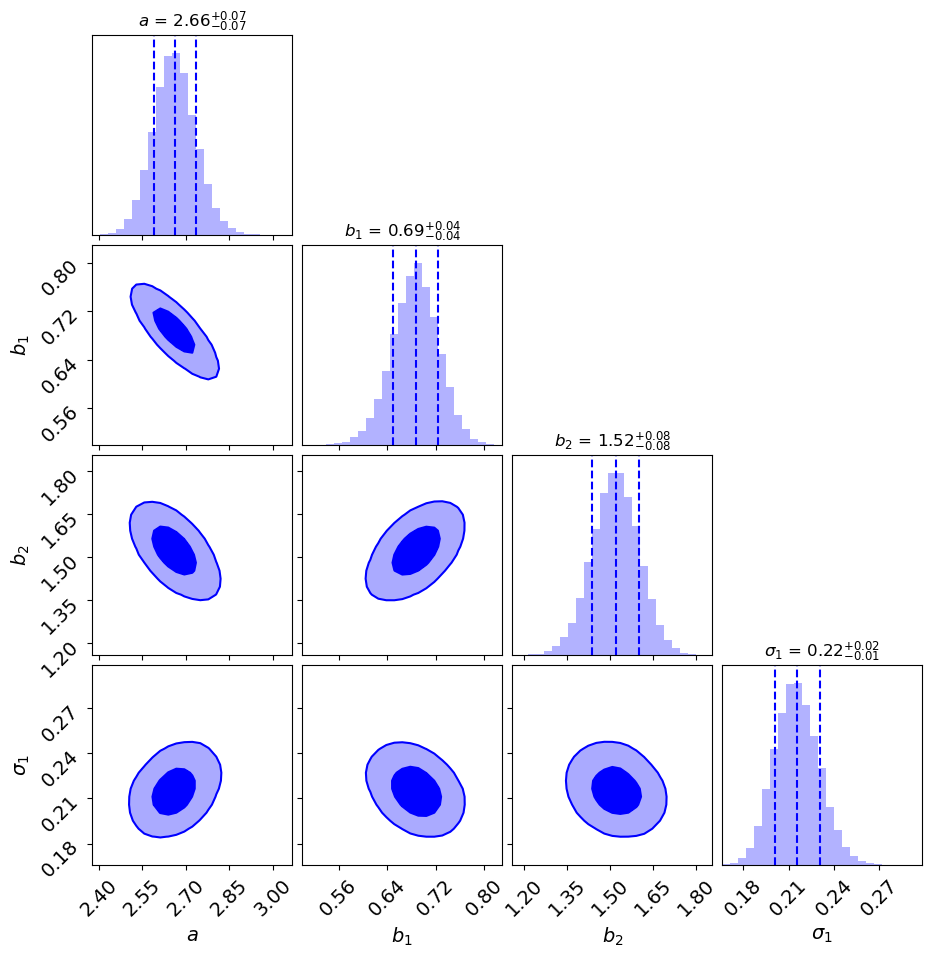

In [19]:
fig = corner(my_mcmc_samples.T, bins=25, smooth=1,
             labels=['$a$', '$b_1$', '$b_2$', r'$\sigma_1$'], #r'$\sigma_2$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12});

In [20]:
hf_test.ndata[-1] < 3, mlf.ndata[-1] < 3

(True, True)

In [21]:
mlf.optimize(bounds, verbose=True)

     fun: -449.42921689327665
     jac: array([-0.00522959, -0.0027967 , -0.01972467,  0.00529781])
 message: 'Optimization terminated successfully.'
    nfev: 3625
     nit: 59
 success: True
       x: array([2.653425  , 0.69103152, 1.52709879, 0.21204488])


(array([2.653425  , 0.69103152, 1.52709879]),
 array([0.232191]),
 449.42921689327665)

In [22]:
hf_test.optimize(bounds, verbose=True)

     fun: -449.42921340945696
     jac: array([-0.05240963, -0.12141754,  0.03010427,  0.02330012])
 message: 'Optimization terminated successfully.'
    nfev: 4355
     nit: 71
 success: True
       x: array([2.65329042, 0.6910609 , 1.52738875, 0.21203966])


(array([2.65329042, 0.6910609 , 1.52738875]),
 array([0.23218529]),
 449.42921340945696)